In [1]:
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

sns.set()

df_wo_inf = pd.read_csv("csvs_final/all_data_final_no_inf.csv")
df_with_inf =  pd.read_csv("csvs_final/all_data_final_with_inf.csv")

df_ss_no_inf = pd.read_csv("csvs_final_subset_paths/all_data_final_no_inf.csv")
df_ss = pd.read_csv("csvs_final_subset_paths/all_data_final.csv")

df_ss['hierarchy'] = df_ss['hierarchy'] + df_ss['method']
df_ss_no_inf['hierarchy'] = df_ss_no_inf['hierarchy'] + df_ss_no_inf['method']

baseline_fillup = pd.read_csv("csvs_final/baseline_fillup.csv")

In [2]:
# to fix errors with saving the pdf https://stackoverflow.com/a/60384073/2745116
from matplotlib import rc
plt.rcParams['pdf.fonttype'] = 42

In [3]:
# map original labels to something else
# only consider k=3 here
label_mapping = {
    '[1]': r'$\hat{k}=1$, full',
#     '[2]': r'$\hat{k}=2$',
    '[2, 4]': r'$\hat{k}=3$, full',
    '[2, 4]two_paths': r'$\hat{k}=3$, 2p',
    '[2, 4]one_path': r'$\hat{k}=3$, 1p',
}

def mapped_labels(original_labels):
    return [label_mapping[l] for l in original_labels]

In [4]:
# combine df with normal/full advertisment & reduced advertisement
# only select central baseline and k=3; sort
full_df_wo_inf = df_ss_no_inf.append(df_wo_inf)
# filter out any infeasible placements (there are still some in df_ss_no_inf) + cast to int
full_df_wo_inf = full_df_wo_inf[full_df_wo_inf['placements'] != 'INFEASIBLE']
full_df_wo_inf['placements'] = full_df_wo_inf['placements'].astype('int')
sub_df_wo_inf = full_df_wo_inf[full_df_wo_inf['hierarchy'].isin(label_mapping.keys())]
# make column categorical and define sort order: https://stackoverflow.com/a/13839029/2745116
sub_df_wo_inf['hierarchy'] = pd.Categorical(sub_df_wo_inf['hierarchy'], ['[1]', '[2, 4]', '[2, 4]two_paths', '[2, 4]one_path'])
sub_df_wo_inf = sub_df_wo_inf.sort_values(by='hierarchy')

<ipython-input-4-d28f66fb7076>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df_wo_inf['hierarchy'] = pd.Categorical(sub_df_wo_inf['hierarchy'], ['[1]', '[2, 4]', '[2, 4]two_paths', '[2, 4]one_path'])


In [5]:
# analyze difference between different approaches
def analyze_ratio(metric, k1_by_k3=False):
    df_k1 = sub_df_wo_inf[sub_df_wo_inf['hierarchy'] == '[1]']
    df_k3 = sub_df_wo_inf[sub_df_wo_inf['hierarchy'] == '[2, 4]one_path']

#     np.mean(df_k3[metric].to_numpy() / df_k1[metric].to_numpy())

    # how much do the means per request deviate?
    ratios = []
    for r in range(1, 6):
        mean_k1 = df_k1[df_k1['request_count'] == r][metric].mean()
        mean_k3 = df_k3[df_k3['request_count'] == r][metric].mean()
        if k1_by_k3:
            ratio = mean_k1 / mean_k3
            print(f'Ratio k1/k3 for {r} requests: {ratio}')
        else:
            ratio = mean_k3 / mean_k1
            print(f'Ratio k3/k1 for {r} requests: {ratio}')
        ratios.append(ratio)
        
    print(f'Min: {min(ratios)}, Max: {max(ratios)}, Mean: {np.mean(ratios)}')

['[1]' '[2, 4]' '[2, 4]one_path' '[2, 4]two_paths']


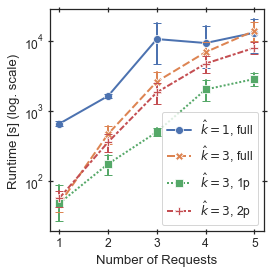

In [17]:
# sns_plot = sns.relplot(data=sub_df_wo_inf, x="request_count", markers=True, y="runtime", style="hierarchy", kind="line", legend='full')
# sns_plot.set(xlabel='Amount of VNF requests', ylabel='Runtime in ms [log]')
# ax = sns_plot.axes[0][0]
# ax.set_yscale("log")
# # plt.legend(title='Approach', loc='lower right', labels=['Baseline', '[1, 2, 4] adv. all paths', '[1, 2, 4] adv. one path' , '[1, 2, 4] adv. two paths'])
# sns_plot.savefig("final_figs_3/final_runtimes_24.pdf")

def plot_runtime(df):
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.set(font_scale=1.1, style='white', rc={'lines.linewidth': 2})
    
    print(df['hierarchy'].unique())
    sns.lineplot(df['request_count'], df['runtime'] / 1000, hue=df['hierarchy'], style=df['hierarchy'], markers=True, markersize=8, legend=False,
                err_style='bars', err_kws={'capsize': 4})
    
    ax.set_xlabel('Number of Requests')
    ax.set_ylabel('Runtime [s] (log. scale)')
    ax.set_yscale('log')
    ax.tick_params(axis='both', direction='inout', length=5, bottom=True, left=True, right=True, top=True)
    plt.legend(labels=mapped_labels(df['hierarchy'].unique()))
    
    plt.tight_layout()
    fig.savefig('final_figs/adv_runtime.pdf')
    
plot_runtime(sub_df_wo_inf)

In [7]:
analyze_ratio('runtime', k1_by_k3=True)

Ratio k1/k3 for 1 requests: 13.67983851257317
Ratio k1/k3 for 2 requests: 9.354794829514018
Ratio k1/k3 for 3 requests: 21.284121401919265
Ratio k1/k3 for 4 requests: 4.60901692450122
Ratio k1/k3 for 5 requests: 4.582817970029614
Min: 4.582817970029614, Max: 21.284121401919265, Mean: 10.702117927707459


In [8]:
# copmare different number of adv paths
df_k1 = sub_df_wo_inf[sub_df_wo_inf['hierarchy'] == '[2, 4]']
df_k3 = sub_df_wo_inf[sub_df_wo_inf['hierarchy'] == '[2, 4]one_path']

# how much do the means per request deviate?
ratios = []
for r in range(1, 6):
    mean_k1 = df_k1[df_k1['request_count'] == r]['runtime'].mean()
    mean_k3 = df_k3[df_k3['request_count'] == r]['runtime'].mean()
    ratio = mean_k1 / mean_k3
    print(f'Ratio k3_full/k3_1p for {r} requests: {ratio}')
    ratios.append(ratio)
print(f'Min: {min(ratios)}, Max: {max(ratios)}, Mean: {np.mean(ratios)}')

Ratio k3_full/k3_1p for 1 requests: 0.9744073243340252
Ratio k3_full/k3_1p for 2 requests: 2.679964545235761
Ratio k3_full/k3_1p for 3 requests: 5.258772336549311
Ratio k3_full/k3_1p for 4 requests: 3.4181695733325643
Ratio k3_full/k3_1p for 5 requests: 4.881823478164279
Min: 0.9744073243340252, Max: 5.258772336549311, Mean: 3.442627451523188


['[1]', '[2, 4]', '[2, 4]two_paths', '[2, 4]one_path']
Categories (4, object): ['[1]', '[2, 4]', '[2, 4]two_paths', '[2, 4]one_path']


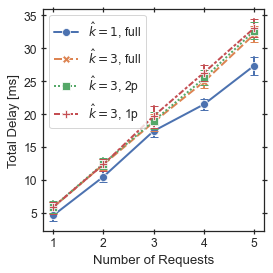

In [9]:
def plot_delay(df):
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.set(font_scale=1.1, style='white', rc={'lines.linewidth': 2})
    
    print(df['hierarchy'].unique())
    sns.lineplot(df['request_count'], df['sum_total_delay'], hue=df['hierarchy'], style=df['hierarchy'], markers=True, markersize=8, legend=False,
                err_style='bars', err_kws={'capsize': 4})
    
    ax.set_xlabel('Number of Requests')
    ax.set_ylabel('Total Delay [ms]')
    ax.tick_params(axis='both', direction='inout', length=5, bottom=True, left=True, right=True, top=True)
    plt.legend(labels=mapped_labels(df['hierarchy'].unique()))
    
    plt.tight_layout()
    fig.savefig('final_figs/adv_total_delay.pdf')
    
plot_delay(sub_df_wo_inf)

['[1]', '[2, 4]', '[2, 4]two_paths', '[2, 4]one_path']
Categories (4, object): ['[1]', '[2, 4]', '[2, 4]two_paths', '[2, 4]one_path']


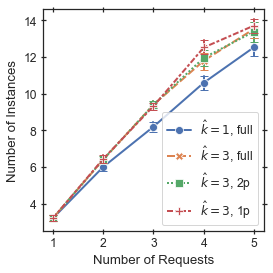

In [10]:
def plot_vnfs(df):
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.set(font_scale=1.1, style='white', rc={'lines.linewidth': 2})
    
    print(df['hierarchy'].unique())
    sns.lineplot(df['request_count'], df['placements'], hue=df['hierarchy'], style=df['hierarchy'], markers=True, markersize=8, legend=False,
                err_style='bars', err_kws={'capsize': 4})
    
    ax.set_xlabel('Number of Requests')
    ax.set_ylabel('Number of Instances')
    ax.tick_params(axis='both', direction='inout', length=5, bottom=True, left=True, right=True, top=True)
    plt.legend(labels=mapped_labels(df['hierarchy'].unique()))
    
    plt.tight_layout()
    fig.savefig('final_figs/adv_num_vnfs.pdf')
    
plot_vnfs(sub_df_wo_inf)

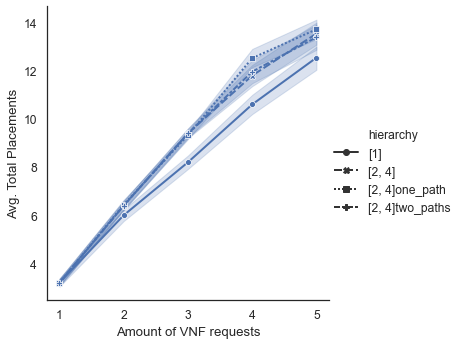

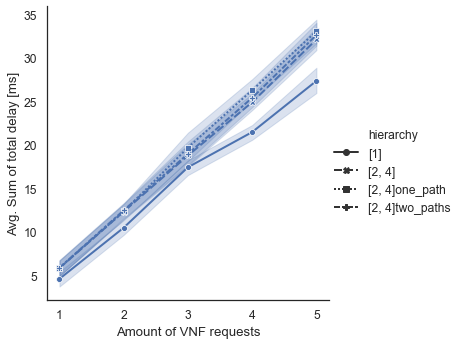

In [11]:
# mirko's code: same plot but different calculation & style
distances = pd.DataFrame(columns=["hierarchy", "gurobi_seed", "vnf_requests_id","requests_count", "amount_placements", "total_delay"])
needed_runs = set()

for (i, gurobi_seed, hierarchy_id, hierarchy, hierarchy_paths, graph_path, vnf_requests_id, ingr_egr, requests_count, vnf_requests_path, placements, runtime, avg_total_delay,avg_e2e_delay,sum_total_delay,sum_e2e_delay, method) in full_df_wo_inf.itertuples():
   # print("hierarchy: {}, gurobi_seed:{}, vnf_requests_id:{}, placements:{}, s_total_delay:{}".format(hierarchy, gurobi_seed, vnf_requests_id,placements, sum_total_delay))
    # now placement distance ->
#     if hierarchy == '[1]' or '[2]' in hierarchy:
    if '[2]' in hierarchy:
        # no loss for baseline
        continue

    if placements == "INFEASIBLE":
        continue

    distance = placements
    tot_delay_distance = sum_total_delay
    distances = distances.append({'hierarchy': hierarchy, 'gurobi_seed':gurobi_seed, 'vnf_requests_id':vnf_requests_id, 'amount_placements':float(distance), 
                                  'total_delay':float(tot_delay_distance), 'requests_count':requests_count}, ignore_index=True)

distances = distances.sort_values(by='hierarchy')
sns_plot = sns.relplot(data=distances, x="requests_count",markers=True, y="amount_placements", style="hierarchy", kind="line", legend='full')
sns_plot.set(xlabel='Amount of VNF requests', ylabel='Avg. Total Placements')
# plt.legend(title='Approach', loc='upper left', labels=['[1, 2, 4] adv. all paths', '[1, 2, 4] adv. one path' , '[1, 2, 4] adv. two paths'])
# sns_plot.savefig("placements.pdf")


sns_plot = sns.relplot(data=distances, x="requests_count",markers=True, y="total_delay", style="hierarchy", kind="line", legend='full')
sns_plot.set(xlabel='Amount of VNF requests', ylabel='Avg. Sum of total delay [ms]')
# plt.legend(title='Approach', loc='upper left', labels=['[1, 2, 4] adv. all paths', '[1, 2, 4] adv. one path' , '[1, 2, 4] adv. two paths'])
plt.xticks(np.arange(1,6,1))
ax1= sns_plot.axes[0][0]
# sns_plot.savefig("delay.pdf")

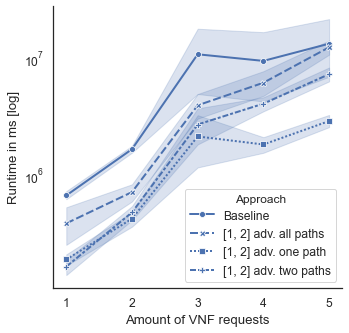

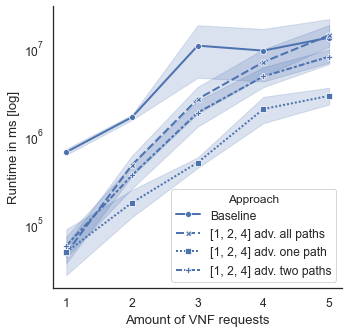

In [12]:
## runtime plots


df_bsline_wo_inf = df_wo_inf[(df_wo_inf.hierarchy=='[1]') | (df_wo_inf.hierarchy=='[2]') | (df_wo_inf.hierarchy=='[2, 4]')]
df_bsline_w_inf = df_with_inf = df_with_inf[(df_with_inf.hierarchy=='[1]') | (df_with_inf.hierarchy=='[2]') | (df_with_inf.hierarchy=='[2, 4]')]



full_df_wo_inf = df_ss_no_inf.append(df_bsline_wo_inf)
full_df_with_inf= df_ss.append(df_bsline_w_inf)


sub_df_wo_inf = full_df_wo_inf[(full_df_wo_inf.hierarchy=="[1]") | (full_df_wo_inf.hierarchy=="[2]") | (full_df_wo_inf.hierarchy=="[2]one_path") | (full_df_wo_inf.hierarchy=="[2]two_paths")]

sub_df_wo_inf = sub_df_wo_inf.sort_values(by='hierarchy')

sns_plot = sns.relplot(data=sub_df_wo_inf, x="request_count", markers=True, y="runtime", style="hierarchy", kind="line", legend=False)
sns_plot.set(xlabel='Amount of VNF requests', ylabel='Runtime in ms [log]')
ax = sns_plot.axes[0][0]
ax.set_yscale("log")
plt.legend(title='Approach', loc='lower right', labels=['Baseline', '[1, 2] adv. all paths', '[1, 2] adv. one path' , '[1, 2] adv. two paths'])
sns_plot.savefig("final_figs_3/final_runtimes_2.pdf")


sub_df_wo_inf = full_df_wo_inf[(full_df_wo_inf.hierarchy=="[1]") | (full_df_wo_inf.hierarchy=="[2, 4]") | (full_df_wo_inf.hierarchy=="[2, 4]one_path") | (full_df_wo_inf.hierarchy=="[2, 4]two_paths")]

sub_df_wo_inf = sub_df_wo_inf.sort_values(by='hierarchy')

sns_plot = sns.relplot(data=sub_df_wo_inf, x="request_count", markers=True, y="runtime", style="hierarchy", kind="line", legend=False)
sns_plot.set(xlabel='Amount of VNF requests', ylabel='Runtime in ms [log]')
ax = sns_plot.axes[0][0]
ax.set_yscale("log")
plt.legend(title='Approach', loc='lower right', labels=['Baseline', '[1, 2, 4] adv. all paths', '[1, 2, 4] adv. one path' , '[1, 2, 4] adv. two paths'])
sns_plot.savefig("final_figs_3/final_runtimes_24.pdf")


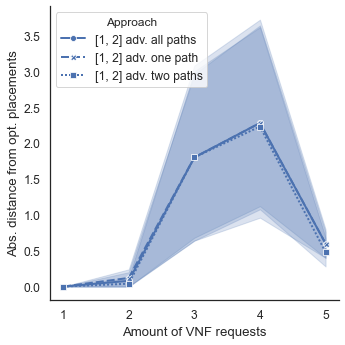

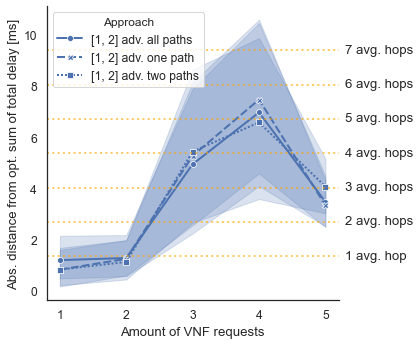

In [13]:
# with inf

distances = pd.DataFrame(columns=["hierarchy", "gurobi_seed", "vnf_requests_id","requests_count", "placements_distance", "total_delay_distance"])

needed_runs = set()

for (i, gurobi_seed, hierarchy_id, hierarchy, hierarchy_paths, graph_path, vnf_requests_id, ingr_egr, requests_count, vnf_requests_path, placements, runtime, avg_total_delay,avg_e2e_delay,sum_total_delay,sum_e2e_delay, method) in full_df_with_inf.itertuples():
   # print("hierarchy: {}, gurobi_seed:{}, vnf_requests_id:{}, placements:{}, s_total_delay:{}".format(hierarchy, gurobi_seed, vnf_requests_id,placements, sum_total_delay))
    # now placement distance ->
    if hierarchy == '[1]' or '[2, 4]' in hierarchy:
        # no loss for baseline
        continue
    next_gurobi_seed = int(gurobi_seed)
    opt = df_bsline_w_inf[(df_bsline_w_inf.hierarchy == '[1]') & (df_bsline_w_inf.gurobi_seed == next_gurobi_seed) & (df_bsline_w_inf.vnf_requests_id == vnf_requests_id)]
    ctr = 0
    while len(opt) == 0 and ctr < 5:
        next_gurobi_seed = int(next_gurobi_seed) + 1 % 5
        opt = df_bsline_w_inf[(df_bsline_w_inf.hierarchy == '[1]') & (df_bsline_w_inf.gurobi_seed == next_gurobi_seed) & (df_bsline_w_inf.vnf_requests_id == vnf_requests_id)]
        ctr += 1
    if len(opt) == 0:
        print("Baseline failed...")
        continue
    
    if placements == 'INFEASIBLE':
        distance = float(opt['placements'])
    else:
        distance = float(abs(float(placements)-float(opt['placements'])))
        
    if distance == 0:
        tot_delay_distance = abs(sum_total_delay - opt['sum_total_delay'])
        avg_e2e_delay_distance = abs(avg_e2e_delay - opt['avg_e2e_delay'] )
        sum_e2e_delay_distance = abs(sum_e2e_delay - opt['sum_e2e_delay'])
        
        distances = distances.append({'hierarchy': hierarchy, 'gurobi_seed':gurobi_seed, 'vnf_requests_id':vnf_requests_id, 'placements_distance':distance,
                                      'total_delay_distance':float(tot_delay_distance), 'requests_count':requests_count, 'e2e_delay_distance':float(avg_e2e_delay_distance),
                                     'sum_e2e_delay_distance': float(sum_e2e_delay_distance)}, ignore_index=True)
    else:
        if placements == 'INFEASIBLE':
            tot_delay_distance = float(opt['sum_total_delay'])
            avg_e2e_delay_distance=float(opt['avg_e2e_delay'])
        else:
            
            bs_fillup = baseline_fillup.query("vnf_requests_id == {} & placements == {}".format(vnf_requests_id, placements))
            tot_delay_opt = bs_fillup['sum_total_delay']
            tot_delay_distance = abs(float(sum_total_delay) - float(tot_delay_opt))
            avg_e2e_delay_opt = bs_fillup['avg_e2e_delay']
            avg_e2e_delay_distance = abs(float(avg_e2e_delay) - float(avg_e2e_delay_opt))
            sum_e2e_delay_opt = bs_fillup['sum_e2e_delay']
            sum_e2e_delay_distance = abs(float(sum_e2e_delay) - float(sum_e2e_delay_opt))
            
        distances = distances.append({'hierarchy': hierarchy, 'gurobi_seed':gurobi_seed, 'vnf_requests_id':vnf_requests_id, 'placements_distance':distance,
                                      'total_delay_distance':tot_delay_distance, 'requests_count':requests_count, 'e2e_delay_distance':float(avg_e2e_delay_distance),
                                     'sum_e2e_delay_distance': float(sum_e2e_delay_distance)}, ignore_index=True)

distances = distances.sort_values(by='hierarchy')

sns_plot = sns.relplot(data=distances, x="requests_count",markers=True, y="placements_distance", style="hierarchy", kind="line", legend=False)
sns_plot.set(xlabel='Amount of VNF requests', ylabel='Abs. distance from opt. placements')
plt.legend(title='Approach', loc='upper left', labels=['[1, 2] adv. all paths', '[1, 2] adv. one path' , '[1, 2] adv. two paths'])

sns_plot.savefig("final_figs_3/2_plcmt_distance_w.pdf")


sns_plot = sns.relplot(data=distances, x="requests_count",markers=True, y="total_delay_distance", style="hierarchy", kind="line", legend=False)
sns_plot.set(xlabel='Amount of VNF requests', ylabel='Abs. distance from opt. sum of total delay [ms]')
plt.legend(title='Approach', loc='upper left', labels=['[1, 2] adv. all paths', '[1, 2] adv. one path' , '[1, 2] adv. two paths'])

plt.xticks(np.arange(1,6,1))
ax1= sns_plot.axes[0][0]

avg_delay = 1.342150105084392
ax1.axhline(avg_delay, ls=':', color='orange', alpha=0.6)
ax1.text(5.3, avg_delay - .1, "1 avg. hop")
ax1.text(5.3, 2 * avg_delay - .1, "2 avg. hops")
ax1.text(5.3, 3* avg_delay - .1, "3 avg. hops")
ax1.text(5.3, 4*avg_delay -.1, "4 avg. hops")
ax1.text(5.3, 5*avg_delay-.1, "5 avg. hops")
ax1.text(5.3, 6*avg_delay-.1, "6 avg. hops")
ax1.text(5.3, 7*avg_delay-.1, "7 avg. hops")
ax1.axhline(2 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(3 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(4 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(5 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(6 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(7 * avg_delay, ls=':', color='orange', alpha=0.6)

sns_plot.savefig("final_figs_3/2_delay_distance_w.pdf")


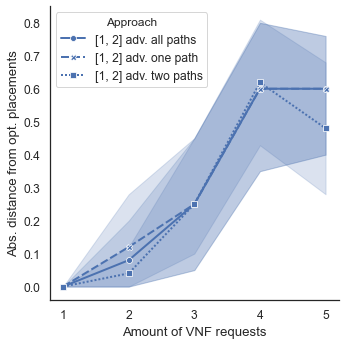

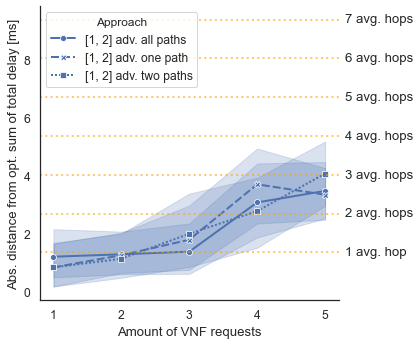

In [14]:
# without inf

distances = pd.DataFrame(columns=["hierarchy", "gurobi_seed", "vnf_requests_id","requests_count", "placements_distance", "total_delay_distance"])

needed_runs = set()

for (i, gurobi_seed, hierarchy_id, hierarchy, hierarchy_paths, graph_path, vnf_requests_id, ingr_egr, requests_count, vnf_requests_path, placements, runtime, avg_total_delay,avg_e2e_delay,sum_total_delay,sum_e2e_delay, method) in full_df_wo_inf.itertuples():
   # print("hierarchy: {}, gurobi_seed:{}, vnf_requests_id:{}, placements:{}, s_total_delay:{}".format(hierarchy, gurobi_seed, vnf_requests_id,placements, sum_total_delay))
    # now placement distance ->
    if hierarchy == '[1]' or '[2, 4]' in hierarchy:
        # no loss for baseline
        continue
    next_gurobi_seed = int(gurobi_seed)
    opt = df_bsline_w_inf[(df_bsline_w_inf.hierarchy == '[1]') & (df_bsline_w_inf.gurobi_seed == next_gurobi_seed) & (df_bsline_w_inf.vnf_requests_id == vnf_requests_id)]
    ctr = 0
    while len(opt) == 0 and ctr < 5:
        next_gurobi_seed = int(next_gurobi_seed) + 1 % 5
        opt = df_bsline_w_inf[(df_bsline_w_inf.hierarchy == '[1]') & (df_bsline_w_inf.gurobi_seed == next_gurobi_seed) & (df_bsline_w_inf.vnf_requests_id == vnf_requests_id)]
        ctr += 1
    if len(opt) == 0:
        print("Baseline failed...")
        continue
    
    if placements == 'INFEASIBLE':
        distance = float(opt['placements'])
        continue
    else:
        distance = float(abs(float(placements)-float(opt['placements'])))
        
    if distance == 0:
        tot_delay_distance = abs(sum_total_delay - opt['sum_total_delay'])
        avg_e2e_delay_distance = abs(avg_e2e_delay - opt['avg_e2e_delay'] )
        sum_e2e_delay_distance = abs(sum_e2e_delay - opt['sum_e2e_delay'])
        
        distances = distances.append({'hierarchy': hierarchy, 'gurobi_seed':gurobi_seed, 'vnf_requests_id':vnf_requests_id, 'placements_distance':distance,
                                      'total_delay_distance':float(tot_delay_distance), 'requests_count':requests_count, 'e2e_delay_distance':float(avg_e2e_delay_distance),
                                     'sum_e2e_delay_distance': float(sum_e2e_delay_distance)}, ignore_index=True)
    else:
        if placements == 'INFEASIBLE':
            tot_delay_distance = float(opt['sum_total_delay'])
            avg_e2e_delay_distance=float(opt['avg_e2e_delay'])
        else:
            
            bs_fillup = baseline_fillup.query("vnf_requests_id == {} & placements == {}".format(vnf_requests_id, placements))
            tot_delay_opt = bs_fillup['sum_total_delay']
            tot_delay_distance = abs(float(sum_total_delay) - float(tot_delay_opt))
            avg_e2e_delay_opt = bs_fillup['avg_e2e_delay']
            avg_e2e_delay_distance = abs(float(avg_e2e_delay) - float(avg_e2e_delay_opt))
            sum_e2e_delay_opt = bs_fillup['sum_e2e_delay']
            sum_e2e_delay_distance = abs(float(sum_e2e_delay) - float(sum_e2e_delay_opt))
        
        distances = distances.append({'hierarchy': hierarchy, 'gurobi_seed':gurobi_seed, 'vnf_requests_id':vnf_requests_id, 'placements_distance':distance,
                                      'total_delay_distance':tot_delay_distance, 'requests_count':requests_count, 'e2e_delay_distance':float(avg_e2e_delay_distance),
                                     'sum_e2e_delay_distance': float(sum_e2e_delay_distance)}, ignore_index=True)


distances = distances.sort_values(by='hierarchy')

sns_plot = sns.relplot(data=distances, x="requests_count",markers=True, y="placements_distance", style="hierarchy", kind="line", legend=False)
sns_plot.set(xlabel='Amount of VNF requests', ylabel='Abs. distance from opt. placements')
plt.legend(title='Approach', loc='upper left', labels=['[1, 2] adv. all paths', '[1, 2] adv. one path' , '[1, 2] adv. two paths'])

sns_plot.savefig("final_figs_3/2_plcmt_distance_wo.pdf")


sns_plot = sns.relplot(data=distances, x="requests_count",markers=True, y="total_delay_distance", style="hierarchy", kind="line", legend=False)
sns_plot.set(xlabel='Amount of VNF requests', ylabel='Abs. distance from opt. sum of total delay [ms]')
plt.legend(title='Approach', loc='upper left', labels=['[1, 2] adv. all paths', '[1, 2] adv. one path' , '[1, 2] adv. two paths'])

plt.xticks(np.arange(1,6,1))
ax1= sns_plot.axes[0][0]

avg_delay = 1.342150105084392
ax1.axhline(avg_delay, ls=':', color='orange', alpha=0.6)
ax1.text(5.3, avg_delay - .1, "1 avg. hop")
ax1.text(5.3, 2 * avg_delay - .1, "2 avg. hops")
ax1.text(5.3, 3* avg_delay - .1, "3 avg. hops")
ax1.text(5.3, 4*avg_delay -.1, "4 avg. hops")
ax1.text(5.3, 5*avg_delay-.1, "5 avg. hops")
ax1.text(5.3, 6*avg_delay-.1, "6 avg. hops")
ax1.text(5.3, 7*avg_delay-.1, "7 avg. hops")
ax1.axhline(2 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(3 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(4 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(5 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(6 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(7 * avg_delay, ls=':', color='orange', alpha=0.6)

sns_plot.savefig("final_figs_3/2_delay_distance_wo.pdf")

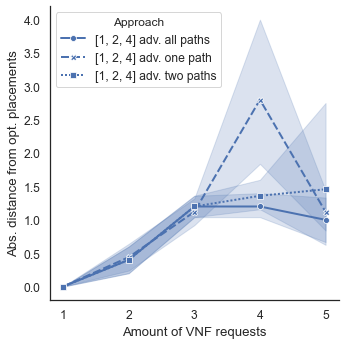

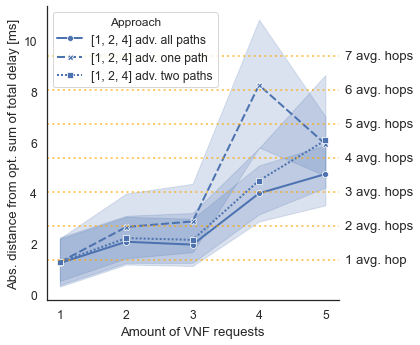

In [15]:
# with inf

distances = pd.DataFrame(columns=["hierarchy", "gurobi_seed", "vnf_requests_id","requests_count", "placements_distance", "total_delay_distance"])

needed_runs = set()

for (i, gurobi_seed, hierarchy_id, hierarchy, hierarchy_paths, graph_path, vnf_requests_id, ingr_egr, requests_count, vnf_requests_path, placements, runtime, avg_total_delay,avg_e2e_delay,sum_total_delay,sum_e2e_delay, method) in full_df_with_inf.itertuples():
   # print("hierarchy: {}, gurobi_seed:{}, vnf_requests_id:{}, placements:{}, s_total_delay:{}".format(hierarchy, gurobi_seed, vnf_requests_id,placements, sum_total_delay))
    # now placement distance ->
    if hierarchy == '[1]' or '[2]' in hierarchy:
        # no loss for baseline
        continue
    next_gurobi_seed = int(gurobi_seed)
    opt = df_bsline_w_inf[(df_bsline_w_inf.hierarchy == '[1]') & (df_bsline_w_inf.gurobi_seed == next_gurobi_seed) & (df_bsline_w_inf.vnf_requests_id == vnf_requests_id)]
    ctr = 0
    while len(opt) == 0 and ctr < 5:
        next_gurobi_seed = int(next_gurobi_seed) + 1 % 5
        opt = df_bsline_w_inf[(df_bsline_w_inf.hierarchy == '[1]') & (df_bsline_w_inf.gurobi_seed == next_gurobi_seed) & (df_bsline_w_inf.vnf_requests_id == vnf_requests_id)]
        ctr += 1
    if len(opt) == 0:
        print("Baseline failed...")
        continue
    
    if placements == 'INFEASIBLE':
        distance = float(opt['placements'])
    else:
        distance = float(abs(float(placements)-float(opt['placements'])))
        
    if distance == 0:
        tot_delay_distance = abs(sum_total_delay - opt['sum_total_delay'])
        avg_e2e_delay_distance = abs(avg_e2e_delay - opt['avg_e2e_delay'] )
        sum_e2e_delay_distance = abs(sum_e2e_delay - opt['sum_e2e_delay'])
        
        distances = distances.append({'hierarchy': hierarchy, 'gurobi_seed':gurobi_seed, 'vnf_requests_id':vnf_requests_id, 'placements_distance':distance,
                                      'total_delay_distance':float(tot_delay_distance), 'requests_count':requests_count, 'e2e_delay_distance':float(avg_e2e_delay_distance),
                                     'sum_e2e_delay_distance': float(sum_e2e_delay_distance)}, ignore_index=True)
    else:
        if placements == 'INFEASIBLE':
            tot_delay_distance = float(opt['sum_total_delay'])
            avg_e2e_delay_distance=float(opt['avg_e2e_delay'])
        else:
            bs_fillup = baseline_fillup.query("vnf_requests_id == {} & placements == {}".format(vnf_requests_id, placements))
            if len(bs_fillup) == 0:
                tot_delay_opt = 0
                avg_e2e_delay_opt = 0
                sum_e2e_delay_opt = 0
            else:
                tot_delay_opt = bs_fillup['sum_total_delay']
                avg_e2e_delay_opt = bs_fillup['avg_e2e_delay']
                sum_e2e_delay_opt = bs_fillup['sum_e2e_delay']
                
            avg_e2e_delay_distance = abs(float(avg_e2e_delay) - float(avg_e2e_delay_opt))
            tot_delay_distance = abs(float(sum_total_delay) - float(tot_delay_opt))
            sum_e2e_delay_distance = abs(float(sum_e2e_delay) - float(sum_e2e_delay_opt))
            
        distances = distances.append({'hierarchy': hierarchy, 'gurobi_seed':gurobi_seed, 'vnf_requests_id':vnf_requests_id, 'placements_distance':distance,
                                      'total_delay_distance':tot_delay_distance, 'requests_count':requests_count, 'e2e_delay_distance':float(avg_e2e_delay_distance),
                                     'sum_e2e_delay_distance': float(sum_e2e_delay_distance)}, ignore_index=True)

distances = distances.sort_values(by='hierarchy')

sns_plot = sns.relplot(data=distances, x="requests_count",markers=True, y="placements_distance", style="hierarchy", kind="line", legend=False)
sns_plot.set(xlabel='Amount of VNF requests', ylabel='Abs. distance from opt. placements')
plt.legend(title='Approach', loc='upper left', labels=['[1, 2, 4] adv. all paths', '[1, 2, 4] adv. one path' , '[1, 2, 4] adv. two paths'])
plt.xticks(np.arange(1,6,1))
sns_plot.savefig("final_figs_3/24_plcmt_distance_w.pdf")


sns_plot = sns.relplot(data=distances, x="requests_count",markers=True, y="total_delay_distance", style="hierarchy", kind="line", legend=False)
sns_plot.set(xlabel='Amount of VNF requests', ylabel='Abs. distance from opt. sum of total delay [ms]')
plt.legend(title='Approach', loc='upper left', labels=['[1, 2, 4] adv. all paths', '[1, 2, 4] adv. one path' , '[1, 2, 4] adv. two paths'])

plt.xticks(np.arange(1,6,1))
ax1= sns_plot.axes[0][0]

avg_delay = 1.342150105084392
ax1.axhline(avg_delay, ls=':', color='orange', alpha=0.6)
ax1.text(5.3, avg_delay - .1, "1 avg. hop")
ax1.text(5.3, 2 * avg_delay - .1, "2 avg. hops")
ax1.text(5.3, 3* avg_delay - .1, "3 avg. hops")
ax1.text(5.3, 4*avg_delay -.1, "4 avg. hops")
ax1.text(5.3, 5*avg_delay-.1, "5 avg. hops")
ax1.text(5.3, 6*avg_delay-.1, "6 avg. hops")
ax1.text(5.3, 7*avg_delay-.1, "7 avg. hops")
ax1.axhline(2 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(3 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(4 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(5 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(6 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(7 * avg_delay, ls=':', color='orange', alpha=0.6)

sns_plot.savefig("final_figs_3/24_delay_distance_w.pdf")

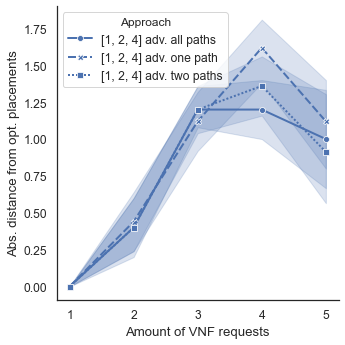

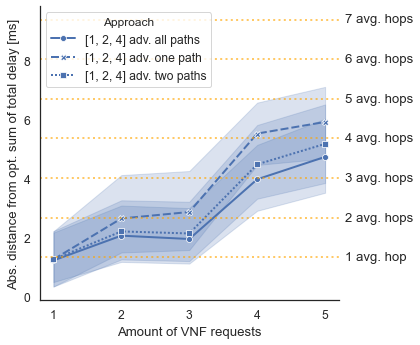

In [16]:
# without inf

distances = pd.DataFrame(columns=["hierarchy", "gurobi_seed", "vnf_requests_id","requests_count", "placements_distance", "total_delay_distance"])

needed_runs = set()

for (i, gurobi_seed, hierarchy_id, hierarchy, hierarchy_paths, graph_path, vnf_requests_id, ingr_egr, requests_count, vnf_requests_path, placements, runtime, avg_total_delay,avg_e2e_delay,sum_total_delay,sum_e2e_delay, method) in full_df_wo_inf.itertuples():
   # print("hierarchy: {}, gurobi_seed:{}, vnf_requests_id:{}, placements:{}, s_total_delay:{}".format(hierarchy, gurobi_seed, vnf_requests_id,placements, sum_total_delay))
    # now placement distance ->
    if hierarchy == '[1]' or '[2]' in hierarchy:
        # no loss for baseline
        continue
    next_gurobi_seed = int(gurobi_seed)
    opt = df_bsline_w_inf[(df_bsline_w_inf.hierarchy == '[1]') & (df_bsline_w_inf.gurobi_seed == next_gurobi_seed) & (df_bsline_w_inf.vnf_requests_id == vnf_requests_id)]
    ctr = 0
    while len(opt) == 0 and ctr < 5:
        next_gurobi_seed = int(next_gurobi_seed) + 1 % 5
        opt = df_bsline_w_inf[(df_bsline_w_inf.hierarchy == '[1]') & (df_bsline_w_inf.gurobi_seed == next_gurobi_seed) & (df_bsline_w_inf.vnf_requests_id == vnf_requests_id)]
        ctr += 1
    if len(opt) == 0:
        print("Baseline failed...")
        continue
    
    if placements == 'INFEASIBLE':
        distance = float(opt['placements'])
        continue
    else:
        distance = float(abs(float(placements)-float(opt['placements'])))
        
    if distance == 0:
        tot_delay_distance = abs(sum_total_delay - opt['sum_total_delay'])
        avg_e2e_delay_distance = abs(avg_e2e_delay - opt['avg_e2e_delay'] )
        sum_e2e_delay_distance = abs(sum_e2e_delay - opt['sum_e2e_delay'])
        
        distances = distances.append({'hierarchy': hierarchy, 'gurobi_seed':gurobi_seed, 'vnf_requests_id':vnf_requests_id, 'placements_distance':distance,
                                      'total_delay_distance':float(tot_delay_distance), 'requests_count':requests_count, 'e2e_delay_distance':float(avg_e2e_delay_distance),
                                     'sum_e2e_delay_distance': float(sum_e2e_delay_distance)}, ignore_index=True)
    else:
        if placements == 'INFEASIBLE':
            tot_delay_distance = float(opt['sum_total_delay'])
            avg_e2e_delay_distance=float(opt['avg_e2e_delay'])
        else:
            bs_fillup = baseline_fillup.query("vnf_requests_id == {} & placements == {}".format(vnf_requests_id, placements))
            if len(bs_fillup) == 0:
                tot_delay_opt = 0
                avg_e2e_delay_opt = 0
                sum_e2e_delay_opt = 0
            else:
                tot_delay_opt = bs_fillup['sum_total_delay']
                avg_e2e_delay_opt = bs_fillup['avg_e2e_delay']
                sum_e2e_delay_opt = bs_fillup['sum_e2e_delay']
                
            avg_e2e_delay_distance = abs(float(avg_e2e_delay) - float(avg_e2e_delay_opt))
            tot_delay_distance = abs(float(sum_total_delay) - float(tot_delay_opt))
            sum_e2e_delay_distance = abs(float(sum_e2e_delay) - float(sum_e2e_delay_opt))
            
        distances = distances.append({'hierarchy': hierarchy, 'gurobi_seed':gurobi_seed, 'vnf_requests_id':vnf_requests_id, 'placements_distance':distance,
                                      'total_delay_distance':tot_delay_distance, 'requests_count':requests_count, 'e2e_delay_distance':float(avg_e2e_delay_distance),
                                     'sum_e2e_delay_distance': float(sum_e2e_delay_distance)}, ignore_index=True)


distances = distances.sort_values(by='hierarchy')

sns_plot = sns.relplot(data=distances, x="requests_count",markers=True, y="placements_distance", style="hierarchy", kind="line", legend=False)
sns_plot.set(xlabel='Amount of VNF requests', ylabel='Abs. distance from opt. placements')
plt.legend(title='Approach', loc='upper left', labels=['[1, 2, 4] adv. all paths', '[1, 2, 4] adv. one path' , '[1, 2, 4] adv. two paths'])

sns_plot.savefig("final_figs_3/24_plcmt_distance_wo.pdf")


sns_plot = sns.relplot(data=distances, x="requests_count",markers=True, y="total_delay_distance", style="hierarchy", kind="line", legend=False)
sns_plot.set(xlabel='Amount of VNF requests', ylabel='Abs. distance from opt. sum of total delay [ms]')
plt.legend(title='Approach', loc='upper left', labels=['[1, 2, 4] adv. all paths', '[1, 2, 4] adv. one path' , '[1, 2, 4] adv. two paths'])

plt.xticks(np.arange(1,6,1))
ax1= sns_plot.axes[0][0]

avg_delay = 1.342150105084392
ax1.axhline(avg_delay, ls=':', color='orange', alpha=0.6)
ax1.text(5.3, avg_delay - .1, "1 avg. hop")
ax1.text(5.3, 2 * avg_delay - .1, "2 avg. hops")
ax1.text(5.3, 3* avg_delay - .1, "3 avg. hops")
ax1.text(5.3, 4*avg_delay -.1, "4 avg. hops")
ax1.text(5.3, 5*avg_delay-.1, "5 avg. hops")
ax1.text(5.3, 6*avg_delay-.1, "6 avg. hops")
ax1.text(5.3, 7*avg_delay-.1, "7 avg. hops")
ax1.axhline(2 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(3 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(4 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(5 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(6 * avg_delay, ls=':', color='orange', alpha=0.6)
ax1.axhline(7 * avg_delay, ls=':', color='orange', alpha=0.6)

sns_plot.savefig("final_figs_3/24_delay_distance_wo.pdf")